## RAG

### 1. Load the data from HuggingFace

In [21]:
from datasets import load_dataset
import pandas as pd

# Load the dataset from 
ds = load_dataset("MedRAG/pubmed")

# Get the train data， first 5k samples
train_data = ds['train']

df = pd.DataFrame(train_data[:5000])

# Save the whole train data to a csv file
df.to_csv('train.csv', index=False)

### 2. Data cleaning

In [22]:
import spacy
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
nlp = spacy.load('en_core_web_sm')

In [23]:
data_raw = pd.read_csv('train.csv')

In [24]:
data_raw.head()

,id,title,content,contents,PMID
0,pubmed23n0001_0,[Biochemical studies on camomile components/II...,(--)-alpha-Bisabolol has a primary antipeptic ...,[Biochemical studies on camomile components/II...,21
1,pubmed23n0001_1,[Demonstration of tumor inhibiting properties ...,A report is given on the recent discovery of o...,[Demonstration of tumor inhibiting properties ...,22
2,pubmed23n0001_2,Effect of etafenone on total and regional myoc...,The distribution of blood flow to the subendoc...,Effect of etafenone on total and regional myoc...,23
3,pubmed23n0001_3,Influence of a new virostatic compound on the ...,"The virostatic compound N,N-diethyl-4-[2-(2-ox...",Influence of a new virostatic compound on the ...,24
4,pubmed23n0001_4,Pharmacological properties of new neuroleptic ...,"RMI 61 140, RMI 61 144 and RMI 61 280 are newl...",Pharmacological properties of new neuroleptic ...,25


"The 'contents' field combines the title and main text, but includes many stop words and irrelevant symbols. We need to remove them to improve retrieval accuracy."

In [25]:
data_raw.iloc[0]['contents']

"[Biochemical studies on camomile components/III. In vitro studies about the antipeptic activity of (--)-alpha-bisabolol (author's transl)]. (--)-alpha-Bisabolol has a primary antipeptic action depending on dosage, which is not caused by an alteration of the pH-value. The proteolytic activity of pepsin is reduced by 50 percent through addition of bisabolol in the ratio of 1/0.5. The antipeptic action of bisabolol only occurs in case of direct contact. In case of a previous contact with the substrate, the inhibiting effect is lost."

The contents length ranges from 22 to 511, with the mean of 161.  

In [44]:
print("Min Length: " + data_raw['contents'].apply(lambda x: len(x.split(' '))).min().astype(str))
print("Max Length: " + data_raw['contents'].apply(lambda x: len(x.split(' '))).max().astype(str))
print("Mean Length:" + data_raw['contents'].apply(lambda x: len(x.split(' '))).mean().astype(str))

Min Length: 22
Max Length: 511
Mean Length:161.8228


<Axes: ylabel='Frequency'>

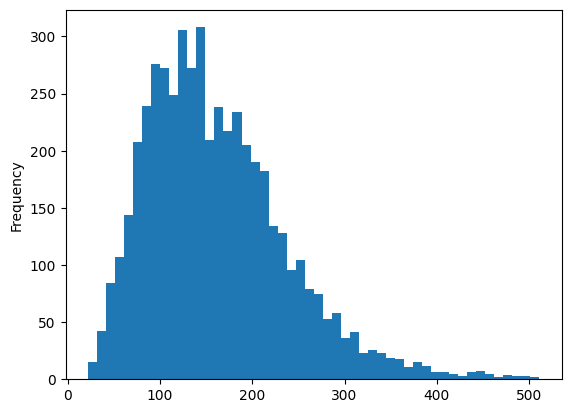

In [26]:
data_raw['contents'].apply(lambda x: len(x.split(' '))).plot(kind='hist', bins=50)

In [27]:
doc = nlp(data_raw.iloc[0]['contents'])

Only the Alphanumeric words are important, whitespace, punctuation and stop words should be excluded.

In [28]:
def token_to_df(doc=doc):
    token_info = []
    for token in doc:
        token_info.append({
            "Text": token.text,
            "Index": token.idx,
            "Whitespace": token.is_space,
            "Is Alphanumeric?": token.is_alpha,
            "Is Punctuation?": token.is_punct,
            "Is Stop Word?": token.is_stop
        })
    return pd.DataFrame(token_info)

token_to_df(doc)

,Text,Index,Whitespace,Is Alphanumeric?,Is Punctuation?,Is Stop Word?
0,[,0,False,False,True,False
1,Biochemical,1,False,True,False,False
2,studies,13,False,True,False,False
3,on,21,False,True,False,True
4,camomile,24,False,True,False,False
...,...,...,...,...,...,...
98,inhibiting,509,False,True,False,False
99,effect,520,False,True,False,False
100,is,527,False,True,False,True
101,lost,530,False,True,False,False


Lemmatization is necessary to reduce the length of the content while preserving relevant information.

In [29]:
for token in doc:
    if str(token) != str(token.lemma_):
        print(f"{str(token):>20} : {str(token.lemma_)}")

         Biochemical : biochemical
             studies : study
          components : component
                  In : in
             studies : study
                 has : have
           depending : depend
                  is : be
              caused : cause
                  pH : ph
                 The : the
                  is : be
             reduced : reduce
                 The : the
              occurs : occur
                  In : in
          inhibiting : inhibit
                  is : be
                lost : lose


In [30]:
def clean_text(text):
    complete_doc = nlp(text)
    words = [token.text for token in complete_doc 
             if token.is_alpha and not token.is_stop and not token.is_punct]
    return ' '.join(words)

def lemmalize_text(text):
    complete_doc = nlp(text)
    words = [token.lemma_ for token in complete_doc]
    return ' '.join(words)

In [31]:
text = data_raw.iloc[0]['contents']
text = clean_text(text)
text = lemmalize_text(text)
clean_doc = nlp(text)

After cleaning, the first contents length is reduced from 103 to 44.

In [32]:
token_to_df(clean_doc).shape[0]

44

Tokenization

In [33]:
def tokenized_text(text):
    complete_doc = nlp(text)
    words = [token.text.lower() for token in complete_doc]
    return words

Overall Cleaning Process(Takes 2.5 minutes to run)

In [36]:
def full_preprocessing(text):
    text = clean_text(text)
    text = lemmalize_text(text)
    text = tokenized_text(text)
    return ' '.join(text)

data_clean = data_raw.copy()
data_clean['cleaned'] = data_raw['contents'].transform(full_preprocessing)

After cleaning, the contents length ranges from 14 to 267, with the mean of 90. 

In [45]:
print("Min Length: " + data_clean['cleaned'].apply(lambda x: len(x.split(' '))).min().astype(str))
print("Max Length: " + data_clean['cleaned'].apply(lambda x: len(x.split(' '))).max().astype(str))
print("Mean Length:" + data_clean['cleaned'].apply(lambda x: len(x.split(' '))).mean().astype(str))

Min Length: 14
Max Length: 267
Mean Length:90.8558


<Axes: ylabel='Frequency'>

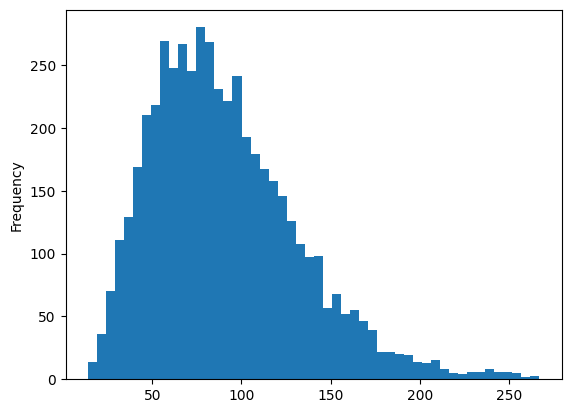

In [46]:
data_clean['cleaned'].apply(lambda x: len(x.split(' '))).plot(kind='hist', bins=50)

In [47]:
data_clean.to_csv('train_clean.csv', index=False)

### 3. Bi-encoder Implementation

In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import torch
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('train_clean.csv')
data_str = data['cleaned'].tolist()

# Load the SentenceTransformer model
model = SentenceTransformer("all-MiniLM-L6-v2", device='cuda' if torch.cuda.is_available() else 'cpu')

# Encode the dataset
embeddings = model.encode(data_str)

# Preprocess the query
query_cleaned = clean_text(query)
query_lemmatized = lemmalize_text(query_cleaned)
query_tokenized = tokenized_text(query_lemmatized)
query_new = ' '.join(query_tokenized)

# Encode the query
query_embedding = model.encode([query_new])

# Compute similarities
similarities = model.similarity(query_embedding, embeddings)

# Get the top `n` most similar papers
similarities_tensor = torch.tensor(similarities)
top_n_values, top_n_indices = torch.topk(similarities_tensor, n)
top_n_indices = top_n_indices.tolist()[0]